<a href="https://www.kaggle.com/paulwightmore/ai-synth-part-1-an-investigation?scriptVersionId=87512031" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from typing import Iterable, Mapping


/kaggle/input/pure-waveforms/waveforms.csv


Question: What would it take to create an AI based synth.
Answer: I have no idea, but let's give it a shot.

**Part I - Waveform characteristics**

Given a fixed size waveform, can we use AI to categorise the input and to provide a set of outputs representing the waveforms characteristics?

What characteristics?

- Type (sine, sawtooth, square)
- Phase (0.0 0 degs, 1.0 180 degs)
- Attack (0.0 not attack - whatever that means, 1.0 instant on)
- Volume/power
- Decay (0.0 does not decay, 1.0 instant off)
- Harmonics (various standard harmonics e.g. 3rd_harmonic - 0.0 harmonic does not exist, 1.0 harmonic at full intensity)

**Part II - Waveform generation**

Given a set of user controlable characteristics produce a suitable waveform - this could be done, for example, by using sliders for assigning the amount by which a characteristic is present in the output waveform.

**Part III - ???**

???

...some time later...

**Part IV - Fully functional AI generating wavetable synthesizer**

...some more time later...

**Part V - Generate waveform parameters from real instrument samples**

Analyse a sample of a real instrument in order to generate a set of characteristics that allows the sample to be regenerated as closely as the model will allow (given an abundance of additional parameters, temporal capabilities).

What to make your new piano sample more synthetic? No problem just adjust the sine and sawtooth characteristic sliders and watch your new waveform transform in near real time.

Disclaimer: I have no intention of seeing this through, maybe I'll play around to see what I can come up with for part I and part II.
Additional disclaimer: I have no professional nor practical experience of neural nets and I am using the above as an exercise in broadaning my experience.

Firstly from previous iterations, there was a need for some knowledge of the current context (e.g. what is the global sample rate) and in addition to this some helper functions for manipulating sample and time conversions; more importantly some of these functions provided the ability to be implemented as [generators]<sup>*</sup>.(https://realpython.com/introduction-to-python-generators/)

<sup>*</sup>My goal is to avoid passing around huge arrays of numbers where ever possible.

In [2]:
class context:
    def __init__(self, sample_rate: int):
        self.sample_rate = sample_rate
        
    def __str__(self):
        return f'context(sample_rate: {self.sample_rate})'
    
    #def sample_rate(self):
    #    return self.sample_rate
    
class sample_context_helper:
    def __init__(self, context: context):
        self.context = context
    
    def time_range(self, t1: float, t2: float, t_steps: int):
        dt = (t2 - t1) / t_steps
        for s in range(0, t_steps):
            yield t1 + s * dt
        
    def sample_count_to_timespan(self, sample_count: int): 
        return float(sample_count) / float(self.context.sample_rate)
        
    def sample_count_to_time_range(self, sample_count: int, sample_offset: int = 0):
        for s in range(sample_offset, (sample_count + sample_offset)):
            yield s / self.context.sample_rate
            
    def timespan_to_sample_count(self, timespan: float): 
        return int(0.5 + timespan * self.context.sample_rate)
    
    def timespan_to_time_range(self, timespan: float, time_offset: float = 0.0):
        sample_count = self.timespan_to_sample_count(timespan)
        sample_count += self.timespan_to_sample_count(time_offset)
        return self.sample_count_to_time_range(sample_count)

ctx = context(sample_rate=48)

print(ctx)

context(sample_rate: 48)


Let's quickly test that.

In [3]:
default_step = 0.1;
default_timespan = 1.0;
#default_timespan_range = np.arange(0.0, default_timespan + default_step, default_step);

In [4]:
ctx_hlp = sample_context_helper(ctx)

print(f'1 sec = {ctx_hlp.timespan_to_sample_count(1.0)} samples')
print(f'2.5 sec = {ctx_hlp.timespan_to_sample_count(2.5)} samples')
print(f'48 samples = {ctx_hlp.sample_count_to_timespan(48)} secs')
print(f'120 samples = {ctx_hlp.sample_count_to_timespan(120)} secs')

print("time range of 1 sec to 2.5 sec over 10 steps:")
time_range = np.fromiter(ctx_hlp.time_range(1.0, 2.5, 10), float)
print(time_range)

print("time range of 48 samples:")
time_range = np.fromiter(ctx_hlp.sample_count_to_time_range(48), float)
print(time_range)

print("time range of 1 sec:")
time_range = np.fromiter(ctx_hlp.timespan_to_time_range(1.0), float)
print(time_range)

default_timespan_range = np.fromiter(ctx_hlp.timespan_to_time_range(default_timespan), float)

1 sec = 48 samples
2.5 sec = 120 samples
48 samples = 1.0 secs
120 samples = 2.5 secs
time range of 1 sec to 2.5 sec over 10 steps:
[1.   1.15 1.3  1.45 1.6  1.75 1.9  2.05 2.2  2.35]
time range of 48 samples:
[0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.39583333 0.41666667 0.4375     0.45833333 0.47916667
 0.5        0.52083333 0.54166667 0.5625     0.58333333 0.60416667
 0.625      0.64583333 0.66666667 0.6875     0.70833333 0.72916667
 0.75       0.77083333 0.79166667 0.8125     0.83333333 0.85416667
 0.875      0.89583333 0.91666667 0.9375     0.95833333 0.97916667]
time range of 1 sec:
[0.         0.02083333 0.04166667 0.0625     0.08333333 0.10416667
 0.125      0.14583333 0.16666667 0.1875     0.20833333 0.22916667
 0.25       0.27083333 0.29166667 0.3125     0.33333333 0.35416667
 0.375      0.39583333 0.416666

First things first. Let's provide a wave of generating some waveforms in code. From this we can then generate a series of samples and build up a dataset library...

In [5]:
import math
   
class signal_generator:
    def __init__(self, context: context):
        self.context = context
        self.ctx_hlp = sample_context_helper(context)
        
    def _calc_t(self, timepoint: float):
        return timepoint
    
    def _generate_raw_sample(self, t: float):
        return 0.0
    
    def _generate_cooked_sample(self, t: float):
        return self._generate_raw_sample(t)
            
    def generate_sample(self, timepoint: float):
        t = self._calc_t(timepoint)
        return self._generate_cooked_sample(t)
    
    def generate_samples(self, tp1: float, tp2: float):
        sample_count = self.ctx_hlp.timespan_to_sample_count(tp2-tp1)
        t1 = self._calc_t(tp1)
        t2 = self._calc_t(tp2)
        for t in self.ctx_hlp.time_range(t1, t2, sample_count):
            yield self._generate_cooked_sample(t)
            
class waveform_generator(signal_generator):
    def __init__(self, context: context, phase: float):
        super().__init__(context)
        self.phase = phase
    
    def _calc_t(self, timepoint: float):
        return self.phase + timepoint

Set up a basic test environment that will allow us to plot our generator classes

In [6]:
class plot_helper:
    def __init__(self, context: context):
        self.context = context
        self.ctx_hlp = sample_context_helper(context)
        
    def plot_signal(self, generator: signal_generator, timespan = default_timespan, t0 = 0.0, title: str = None):
        samples = np.fromiter(generator.generate_samples(t0, timespan), float)

        time_range = self.ctx_hlp.time_range(t0, timespan, len(samples))
        df = pd.DataFrame(samples, time_range)
        df.plot(title = title)
 
plt = plot_helper(ctx)

Plot the out put of the sine generator

In [7]:
class sine_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def _generate_raw_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return math.sin(2.0 * math.pi * t)


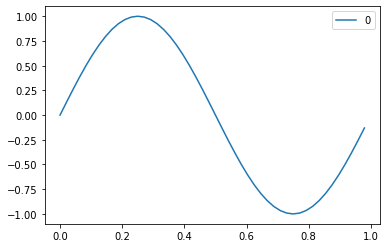

In [8]:
sine_gen = sine_wave_generator(ctx)

plt.plot_signal(sine_gen)

In [9]:
class cosine_wave_generator(sine_wave_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase + 0.25)


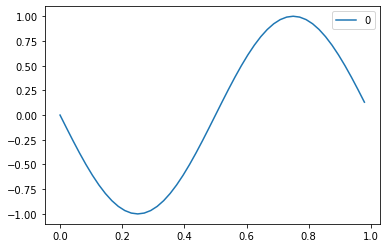

In [10]:
cosine_gen = cosine_wave_generator(ctx)

plt.plot_signal(cosine_gen)

Now let's create a simple square wave generator

In [11]:
class square_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def _generate_raw_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return 1.0 if t < 0.5 else -1.0 

Plot the out put of the square wave generator

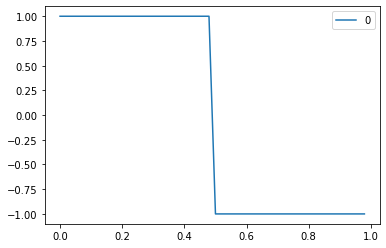

In [12]:
square_gen = square_wave_generator(ctx)

plt.plot_signal(square_gen)

That was pretty straight forward, a sawtooth generator shouldn't be that much more of a stretch.

In [13]:
class sawtooth_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def _generate_raw_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return 2.0 * (t if t < 0.5 else t - 1.0)

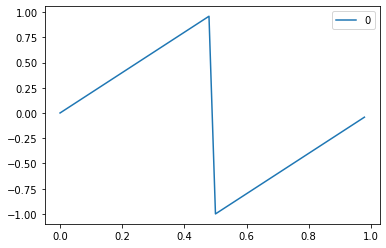

In [14]:
sawtooth_gen = sawtooth_wave_generator(ctx, phase = 0.0)

plt.plot_signal(sawtooth_gen)

We have some generator classes, now let's create a class for generating a series of samples at a given frequency over a given period of time

In [15]:
class triangle_wave_generator(waveform_generator):
    def __init__(self, context: context, phase: float = 0.0):
        super().__init__(context, phase)
        
    def _generate_raw_sample(self, timepoint: float):
        t = math.fmod(timepoint + self.phase, 1.0)
        return 4.0 * (t if t < 0.25 else 0.5 - t if t < 0.75 else t- 1.0)

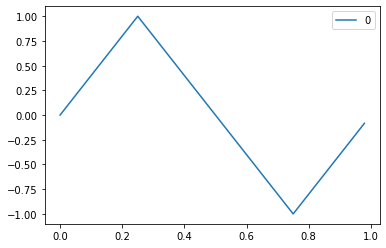

In [16]:
triangle_gen = triangle_wave_generator(ctx, phase = 0.0)

plt.plot_signal(triangle_gen)

In [17]:
class tweakable_signal_generator(signal_generator):
    def __init__(self, context: context, frequency: float, amplitude: float, phase: float, bias: float, attenuation: float):
        super().__init__(context)
        self.frequency = frequency
        self.amplitude = amplitude
        self.phase = phase
        self.bias = bias
        self.attenuation = attenuation
        
    def _calc_t(self, timepoint: float):
        return self.phase + timepoint * self.frequency
    
    #def _generate_raw_sample(self, t: float):
    #    return 0.0
    
    def _generate_cooked_sample(self, t: float):
        return self.bias + self.amplitude * self._generate_raw_sample(t)
            
    #def generate_sample(self, timepoint: float):
    #    t = self._calc_t(timepoint)
    #    return self._generate_cooked_sample(t)
    
    #def generate_samples(self, timespan: float):
    #    #amplitude = 1.0 - self.attenuation
    #    t1 = self._calc_t(0)
    #    t2 = self._calc_t(timespan)
    #    sample_count = self.ctx_hlp.timespan_to_sample_count(timespan)
    #    for t in self.ctx_hlp.time_range(t1, t2, sample_count):
    #        yield self._generate_cooked_sample(t)
    
    
class waveform_signal_generator(tweakable_signal_generator):
    def __init__(self, context: context, generator: waveform_generator, frequency: float, amplitude: float = 1.0, phase: float = 0.0, bias: float = 0.0, attenuation: float = 0.0):
        super().__init__(context, frequency, amplitude, phase, bias, attenuation)
        self.generator = generator
        
    def _generate_raw_sample(self, t: float):
        return self.generator.generate_sample(t)


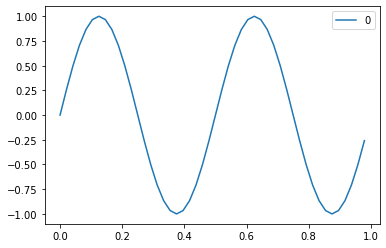

In [18]:
sine_sig_gen_2hz = waveform_signal_generator(ctx, sine_gen, frequency = 2.0)

plt.plot_signal(sine_sig_gen_2hz)


Test sine wave again, this time with a phase shift applied at the signal generator level

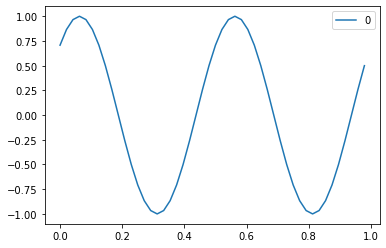

In [19]:
sine_sig_gen_2hz_45degs = waveform_signal_generator(ctx, sine_gen, frequency = 2.0, phase = 0.125)

plt.plot_signal(sine_sig_gen_2hz_45degs)

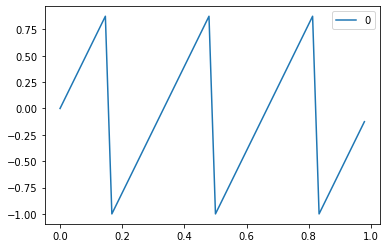

In [20]:
saw_sig_gen_3hz = waveform_signal_generator(ctx, sawtooth_gen, frequency = 3.0)

plt.plot_signal(saw_sig_gen_3hz)

By adding attenuation and bias, we should be able to push a square wave from -1.0 => 1.0 into the 0.0 => 1.0 range

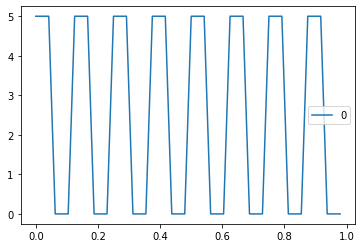

In [21]:
clock_sig_gen_5hz = waveform_signal_generator(ctx, square_gen, frequency = 8.0, amplitude = 2.5, bias = 2.5)

plt.plot_signal(clock_sig_gen_5hz)

Okay, that's the basic signal generation in place. We have a method for creating various pure signals. At somepoint however we may want to start feeding more complex signals through out training program; the most prominent in my mind is how to provide support for harmonics.

We can achieve a more complex signal by mixing<sup>*</sup> multiple signals together...

<sup>*</sup> need to find a more suitable technical term (compositing?)

In [22]:
class compositing_signal_generator(tweakable_signal_generator):
    def __init__(self, context: context, generators: Iterable[signal_generator], frequency: float = 1.0, amplitude: float = 1.0, phase: float = 0.0, bias = 0.0, attenuation: float = 0.0):
        super().__init__(context, frequency, amplitude, phase, bias, attenuation)
        self.generators = generators
        
    def _generate_raw_sample(self, t: float):
        sum = 0.0
        for generator in self.generators:
            sum += generator.generate_sample(t)
        return sum
    

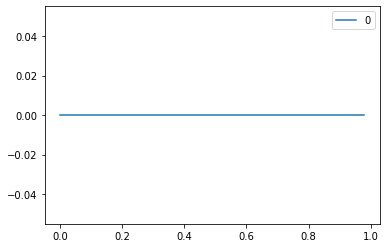

In [23]:
null_signal_generator = compositing_signal_generator(ctx, [])

plt.plot_signal(null_signal_generator)

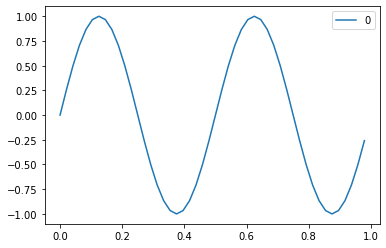

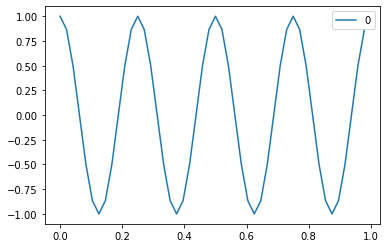

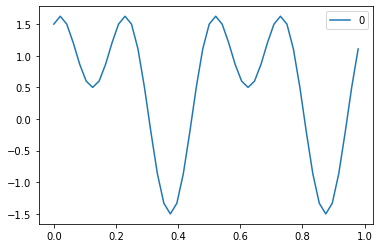

In [24]:
gen1 = waveform_signal_generator(ctx, sine_gen, frequency = 2.0, attenuation = 0.1)
gen2 = waveform_signal_generator(ctx, sine_gen, frequency = 4.0, attenuation = 0.3, phase = 0.25)
comp2_signal_generator = compositing_signal_generator(ctx, [gen1, gen2], bias = 0.5)

plt.plot_signal(gen1)
plt.plot_signal(gen2)
plt.plot_signal(comp2_signal_generator)

My original plan was to somehow use the above generators to generate data tables for storing in some form of overly complicated JSON based data structure. However, as the generators are here and available to use, I may as well store the characteristics of various wave formation in a CSV and then dynamically generate the waveforms required for further processing.

In [25]:
class waveform_generator_factory:
    def __init__(self, context: context):
        self.context = context
        self.generators = {
             'sine': sine_wave_generator,
             'cosine' : cosine_wave_generator,
             'square' : square_wave_generator,
             'sawtooth' : sawtooth_wave_generator,
             'triangle' : triangle_wave_generator}
            
    def create_generator(self, type: str) -> waveform_generator:
        return self.generators[type](self.context)
            
        
class waveform_signal_generator_factory:
    def __init__(self, context: context, wfgf: waveform_generator_factory, data: pd.DataFrame):
        self.context = context
        self.wfgf = wfgf
        self.data = data
        
    def _create_signal_generator(self, data: pd.Series) -> signal_generator:
        type = data['type']     
        frequency = data.get('frequency' , 0.0)
        amplitude = data.get('amplitude' , 1.0)
        phase = data.get('phase' , 0.0) / 360.0 # degs to revolutions
        bias = data.get('bias' , 0.0)
        generator = self.wfgf.create_generator(type)
        
        return waveform_signal_generator(self.context, generator, frequency, amplitude, phase, bias)
    
    def create_signal_generator(self, name: str) -> signal_generator:
        row = self.data[self.data['name'] == name].iloc[0]
        return self._create_signal_generator(row)
            
        
    def create_signal_generators(self) -> Mapping[str, signal_generator]:
        sig_gens = {}
        for index, row in self.data.iterrows():
            name = row['name']
            sig_gens[name] = self._create_signal_generator(row)
            
        return sig_gens

In [26]:
df = pd.DataFrame(
    [['sine_1hz', 'sine', 1.0, 1.0, 0, 0.0],
     ['sine_1hz_45deg', 'sine', 1.0, 1.0, 45.0, 0.0],
     ['sine_1hz_90deg', 'sine', 1.0, 1.0, 90.0, 0.0],
     ['sine_1hz_135deg', 'sine', 1.0, 1.0, 135.0, 0.0],
     ['sine_1hz_180deg', 'sine', 1.0, 1.0, 180.0, 0.0],
     ['cosine_1hz', 'cosine', 1.0, 1.0, 0.0, 0.0],
     ['sine_3hz', 'sine', 3.0, 1.0, 0.0, 0.0],
     ['sine_3hz_45deg', 'sine', 3.0, 1.0, 45.0, 0.0],
     ['sine_3hz_90deg', 'sine', 3.0, 1.0, 90.0, 0.0],
     ['sine_3hz_135deg', 'sine', 3.0, 1.0, 135.0, 0.0],
     ['sine_3hz_180deg', 'sine', 3.0, 1.0, 180.0, 0.0],
     ['cosine_3hz', 'cosine', 3.0, 1.0, 0, 0.0]],
    columns=['name', 'type', 'frequency', 'amplitude', 'phase', 'bias'])

wgf = waveform_generator_factory(ctx)
wfsg = waveform_signal_generator_factory(ctx, wgf, df)

    

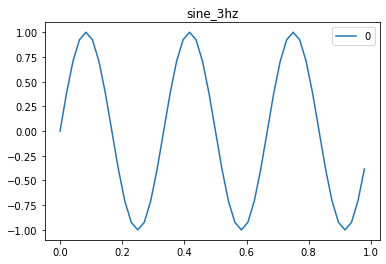

In [27]:
plt.plot_signal(wfsg.create_signal_generator('sine_3hz'), title = 'sine_3hz')

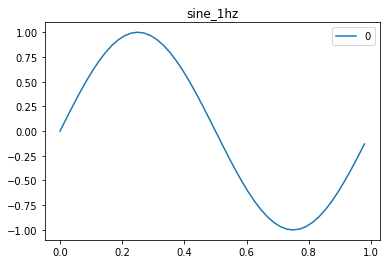

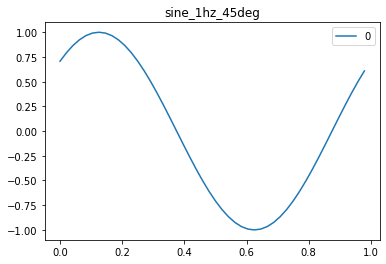

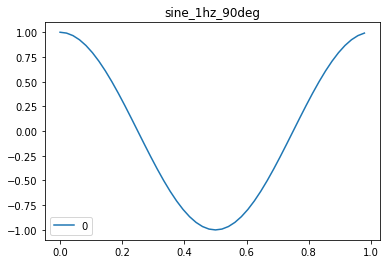

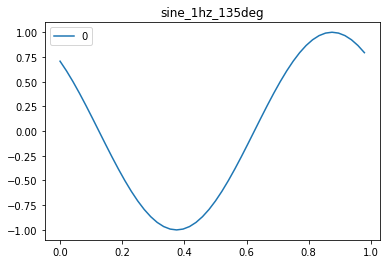

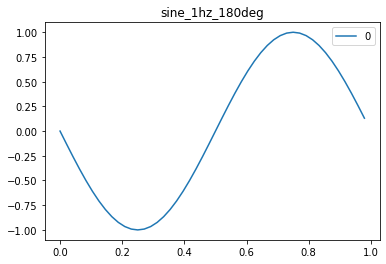

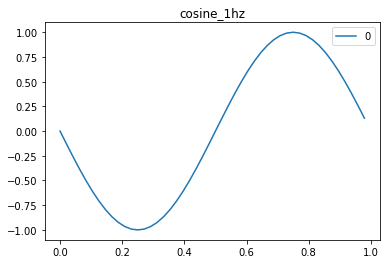

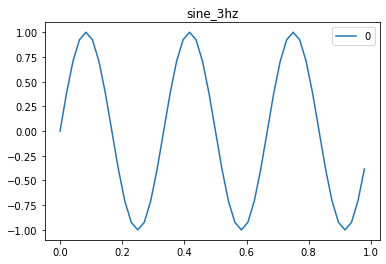

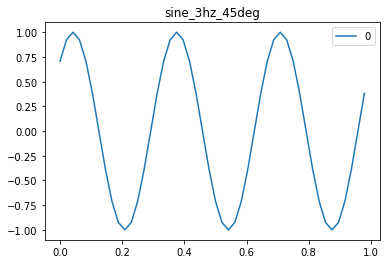

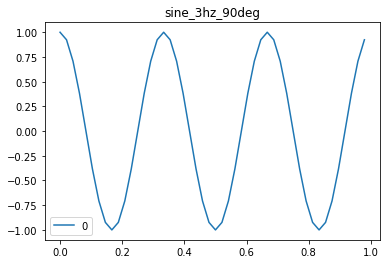

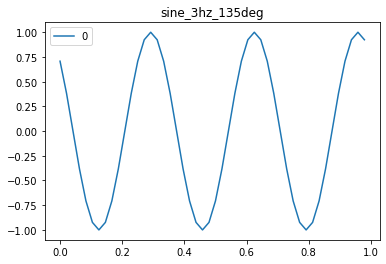

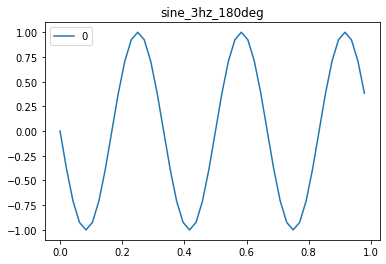

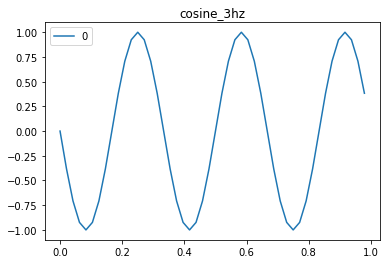

In [28]:
sig_gens = wfsg.create_signal_generators()
for sig_gen_item in sig_gens.items():
    generator = sig_gen_item[1]
    plt.plot_signal(generator, title = sig_gen_item[0])

In [29]:
class composite_signal_generator_factory:
    def __init__(self, context: context, wfsg: waveform_signal_generator_factory, data: pd.DataFrame):
        self.context = context
        self.wfsg = wfsg
        self.data = data
        
    def _create_signal_generator(self, data: pd.Series) -> signal_generator:
        generators = []
        
        signal1Name = data.get('signal1', None)
        if (signal1Name):
            generators.append(self.wfsg.create_signal_generator(signal1Name))
        
        signal2Name = data.get('signal2', None)
        if (signal2Name):
            generators.append(self.wfsg.create_signal_generator(signal2Name))
        
        signal3Name = data.get('signal3', None)
        if (signal3Name):
            generators.append(self.wfsg.create_signal_generator(signal3Name))
        
        signal4Name = data.get('signal4', None)
        if (signal4Name):
            generators.append(self.wfsg.create_signal_generator(signal4Name))
        
        signal5Name = data.get('signal5', None)
        if (signal5Name):
            generators.append(self.wfsg.create_signal_generator(signal5Name))
        
        signal6Name = data.get('signal6', None)
        if (signal6Name):
            generators.append(self.wfsg.create_signal_generator(signal6Name))
        
        return compositing_signal_generator(self.context, generators)
    
    def create_signal_generator(self, name: str) -> signal_generator:
        row = self.data[self.data['name'] == name].iloc[0]
        return self._create_signal_generator(row)
    
    def create_signal_generators(self) -> Mapping[str, signal_generator]:
        sig_gens = {}
        for index, row in self.data.iterrows():
            name = row['name']
            sig_gens[name] = self._create_signal_generator(row)
            
        return sig_gens

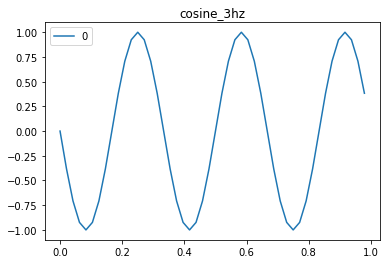

In [30]:
pure_df = pd.DataFrame(
    [['sine_1hz', 'sine_1hz', None, None, None, None],
     ['sine_1hz_45deg', 'sine_1hz_45deg', None, None, None, None],
     ['sine_1hz_90deg', 'sine_1hz_90deg', None, None, None, None],
     ['sine_1hz_135deg', 'sine_1hz_135deg', None, None, None, None],
     ['sine_1hz_180deg', 'sine_1hz_180deg', None, None, None, None],
     ['cosine_1hz', 'cosine_1hz', None, None, None, None],
     ['sine_3hz', 'sine_3hz', None, None, None, None],
     ['sine_3hz_45deg', 'sine_3hz_45deg', None, None, None, None],
     ['sine_3hz_90deg', 'sine_3hz_90deg', None, None, None, None],
     ['sine_3hz_135deg', 'sine_3hz_135deg', None, None, None, None],
     ['sine_3hz_180deg', 'sine_3hz_180deg', None, None, None, None],
     ['cosine_3hz', 'cosine_3hz', None, None, None, None]],
    columns=['name', 'signal1', 'signal2', 'signal3', 'signal4', 'signal5'])

sg = composite_signal_generator_factory(ctx, wfsg, pure_df)

plt.plot_signal(sg.create_signal_generator('cosine_3hz'), title = sig_gen_item[0])


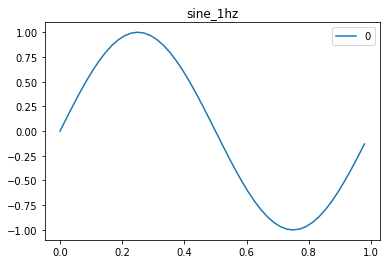

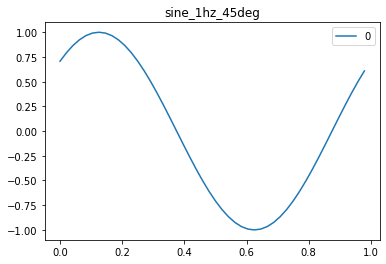

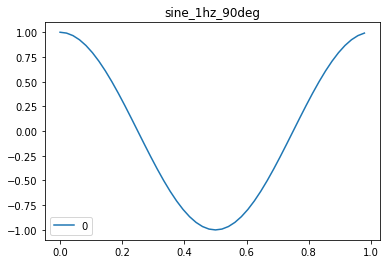

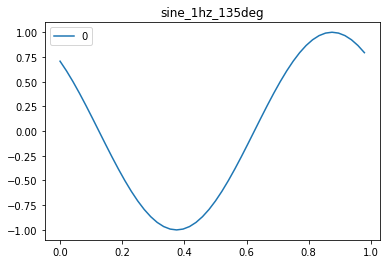

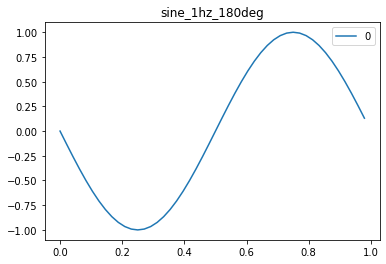

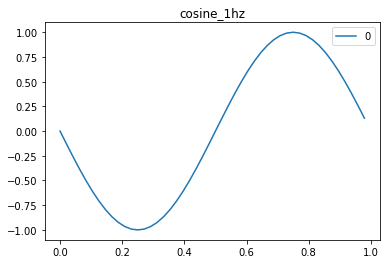

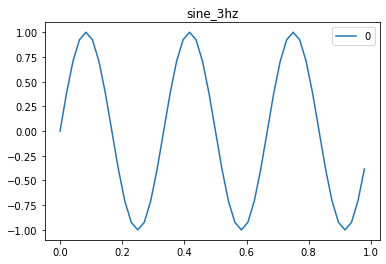

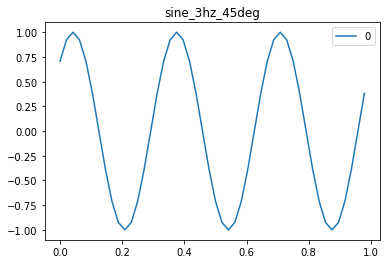

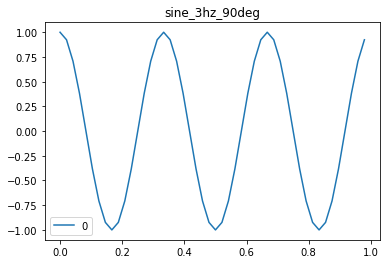

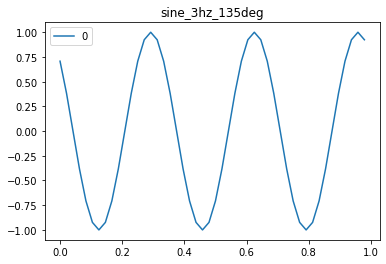

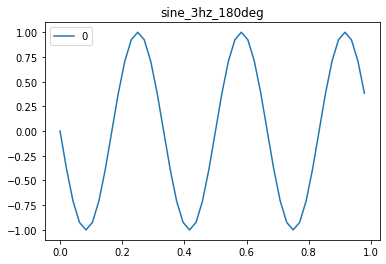

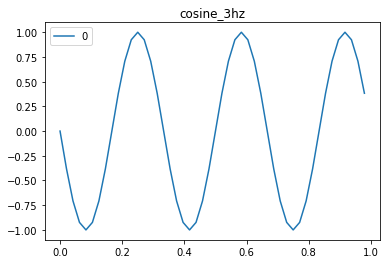

In [31]:
sig_gens = sg.create_signal_generators()
for sig_gen_item in sig_gens.items():
    generator = sig_gen_item[1]
    plt.plot_signal(generator, title = sig_gen_item[0])


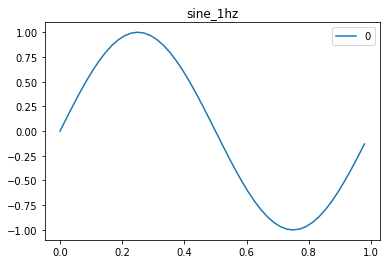

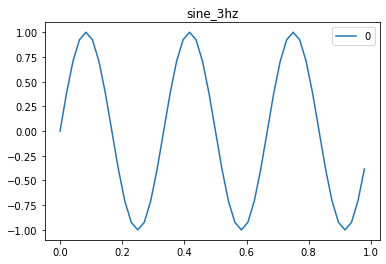

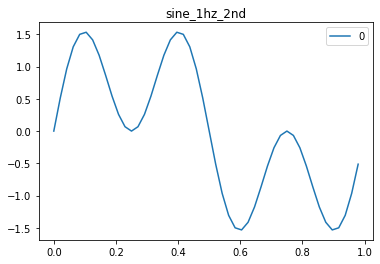

In [32]:
composite_df = pd.DataFrame(
    [['sine_1hz', 'sine_1hz', None, None, None, None],
     ['sine_3hz', 'sine_3hz', None, None, None, None],
     ['sine_1hz_2nd', 'sine_1hz', 'sine_3hz', None, None, None]],
    columns=['name', 'signal1', 'signal2', 'signal3', 'signal4', 'signal5'])

sg = composite_signal_generator_factory(ctx, wfsg, composite_df)

sig_gens = sg.create_signal_generators()
for sig_gen_item in sig_gens.items():
    generator = sig_gen_item[1]
    plt.plot_signal(generator, title = sig_gen_item[0])

TODO: Introduce CNNs, why use CNNs and further more detail the probable use of Keras

- Can use 1 dimensional convolution filter on input signal
- No need to limit signal length and sample rate to a manage NN input nodes
- Support for generators (yay!)

https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial
https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3
https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c



Right, lets try to create a custom Keras data generator. I'm simply hacking together and implementation based on the following [Ronseal<sup>TM</sup>](https://en.wikipedia.org/wiki/Does_exactly_what_it_says_on_the_tin) entitled guide [Write your own Custom Data Generator for TensorFlow Keras](https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3)

In [33]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence
from keras import models
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [34]:
import random

class WaveformDataGenerator(Sequence):
    def __init__(self, context: context,
                 df,
                 batch_size,
                 type_classes,
                 input_size,
                 shuffle=True,
                 to_fit=True,
                 frequency_multiplier_range = 0.0):
        self.context = context
        self.ctx_hlp = sample_context_helper(context)
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.to_fit = to_fit
        self.frequency_multiplier_range = frequency_multiplier_range
        
        n_type = len(type_classes)
        assert df['type'].nunique() <= n_type
        
        # convert type column from text to index
        for type_index in range(0, n_type):
            type_name = type_classes[type_index]
            self.df['type'] = self.df['type'].replace([type_name],type_index)
        
        self.n_type = n_type
        self.n = len(self.df)
        self.index = np.arange(self.n)
        
        # this will force an initial shuffle (if enabled)
        self.on_epoch_end()
        
        wfgf = waveform_generator_factory(self.context)
        self.wfsgf = waveform_signal_generator_factory(self.context, wfgf, df)
        
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.index)
    
    def __get_input(self, name, target_size):
        sig_gen = self.wfsgf.create_signal_generator(name)
        
        t0 = 0
        timespan = self.ctx_hlp.sample_count_to_timespan(target_size)
        
        if self.frequency_multiplier_range > 0.0:
            rf = np.random.normal(loc=0.0, scale=self.frequency_multiplier_range, size=None)
            #rf = random.uniform(-self.frequency_multiplier_range, self.frequency_multiplier_range)
            new_frequency =  sig_gen.frequency + (sig_gen.frequency * rf)
            sig_gen.frequency = new_frequency
        
        return np.fromiter(sig_gen.generate_samples(t0, timespan), float)

    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_y(self, batches):
        # Generates data containing batch_size samples

        type_batch = batches['type']

        #y0_batch = np.asarray([self.__get_output(y, self.n_name) for y in name_batch])
        y0_batch = np.asarray([self.__get_output(y, self.n_type) for y in type_batch])

        return y0_batch
        
    def __get_X(self, batches):
        # Generates data containing batch_size samples

        name_batch = batches['name']
        
        X_batch = np.asarray([self.__get_input(name, self.input_size) for name in name_batch])
        X_batch = X_batch.reshape(X_batch.shape + (1,))
          
        return X_batch
        
    def __getitem__(self, index):
        # map batch index to a range of randomised indicies
        batch_range = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # get the items from the randomized indicies
        batches = self.df.iloc[batch_range]
        
        X = self.__get_X(batches)        
        
        if not self.to_fit:
            return X
        
        y = self.__get_y(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

Just want to verify that  my frequency permutaions are working as expects

frequency 2.0 -> 0.01759207204610129 => 2.0351841440922027
frequency 2.0 -> 0.08079759709033074 => 2.1615951941806615
frequency 2.0 -> -0.01299360084277885 => 1.9740127983144422
frequency 2.0 -> -0.009808324645706537 => 1.9803833507085868
frequency 2.0 -> -0.33473920148507097 => 1.330521597029858
frequency 2.0 -> -0.35298090943961224 => 1.2940381811207755
frequency 2.0 -> -0.1694646538127914 => 1.6610706923744172
frequency 2.0 -> -0.40218745810484724 => 1.1956250837903055
frequency 2.0 -> 0.22812733060940343 => 2.4562546612188068


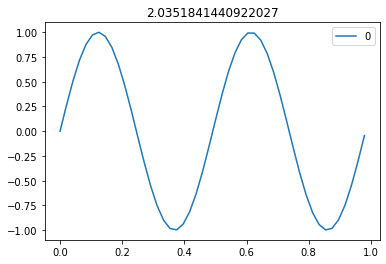

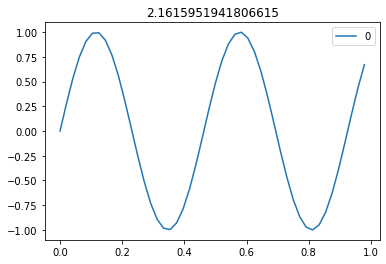

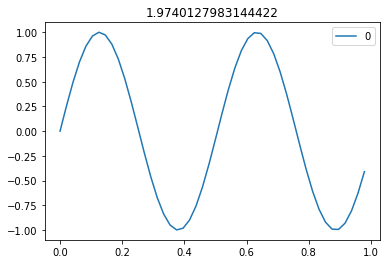

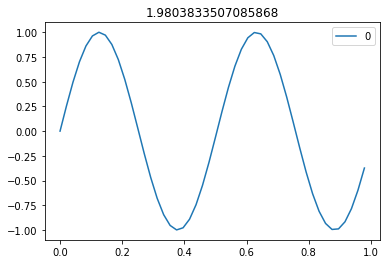

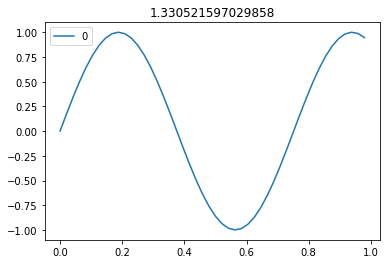

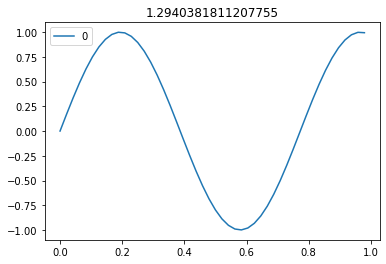

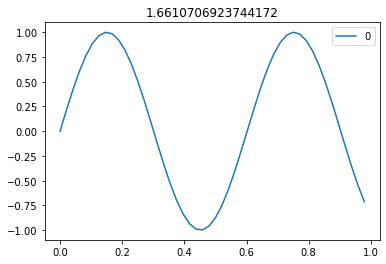

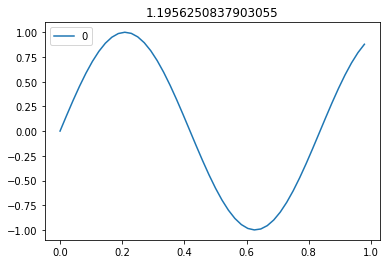

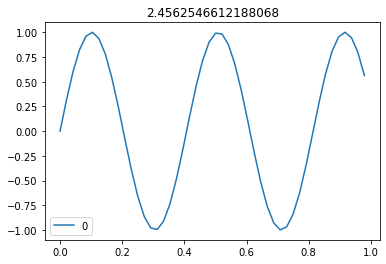

In [35]:
frequency = 2.0
sig_gen = waveform_signal_generator(ctx, sine_gen, frequency = frequency, attenuation = 0.1)
frequency_multiplier_range = 0.2
for i in range(0, 9):
    rf = np.random.normal(loc=0.0, scale=frequency_multiplier_range, size=None)
    #rf = random.uniform(-frequency_multiplier_range, frequency_multiplier_range)
    new_frequency =  frequency + (frequency * rf)
    print(f'frequency {frequency} -> {rf} => {new_frequency}')
    sig_gen.frequency = new_frequency
    plt.plot_signal(sig_gen, title = str(new_frequency))

And now for the important bit

[Convolutional Neural Network (CNN) Tutorial](https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial)

It's at this point that i'm ingorantly copying pasting and tweaking code for processing a 2D image, from the above example, and applying it blindly to a 1D waveform signal.

In [36]:
waveform_dataset = pd.read_csv("/kaggle/input/pure-waveforms/waveforms.csv")

waveform_dataset = waveform_dataset[waveform_dataset['type'] != 'cosine']

type_classes = waveform_dataset['type'].unique()

n_type = len(type_classes)


In [37]:
model = Sequential()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [38]:
# 5x1 filter stage
model.add(Conv1D(filters = 8, kernel_size = 5, padding = 'same', 
                 activation ='relu', input_shape = (256,1)))

model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

In [39]:
# 3x1 filter stage
#
model.add(Conv1D(filters = 16, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))

model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

# fully connected
model.add(Flatten())
model.add(Dense(24, activation = "relu"))  # no. of output layers? was 256 so let's try 16 for input size of 48
model.add(Dropout(0.5))
model.add(Dense(n_type, activation = "softmax"))


In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 8)            48        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 8)            0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           400       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

Compile the module using options that seem to be common across various image CNN examples

In [41]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Now we have a model, let's attempt to train it. For this we need to create a dataset for training and a dataset for validation. Each dataset will have its own data generator, our WaveformDataGenerator, that will be in charge of taking each dataset entry and generating the waveform input and classification outputs.

In [42]:
from sklearn.model_selection import train_test_split

# split the loaded data set into train and test data
train, test = train_test_split(waveform_dataset, test_size=0.2)

# let's create a new context and set a reasonable sample rate for our wave forms (1-8Hz) 
# - we could limit ourselves to the nyquist frequency which would capture frequency information fine but would leave us
# with very course waveform shapes and thus difficult to categorise wave forms at the higher frequencies
model_ctx = context(sample_rate=256)

train_datagen = WaveformDataGenerator(model_ctx, df=train, type_classes = type_classes, input_size = 256, batch_size = 8, shuffle = True, frequency_multiplier_range = 0.01)
test_datagen = WaveformDataGenerator(model_ctx, df=test, type_classes = type_classes, input_size = 256, batch_size = 8)

Now we train for an arbitrary, but hopefully sufficient for testing, number of epochs.
Note that each epoch will present the whole training dataset in a new random order and that the rendered signal frequencies will be permutated for all but the first epoch

In [43]:
model.fit(train_datagen, 
          validation_data = test_datagen,
         epochs=50)

2022-02-10 21:26:50.438044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
10/10 [==============================] - 1s 52ms/step - loss: 1.4762 - accuracy: 0.2875 - val_loss: 1.4035 - val_accuracy: 0.2500
Epoch 2/50
10/10 [==============================] - 0s 25ms/step - loss: 1.4178 - accuracy: 0.1875 - val_loss: 1.4374 - val_accuracy: 0.1250
Epoch 3/50
10/10 [==============================] - 0s 25ms/step - loss: 1.3252 - accuracy: 0.3500 - val_loss: 1.3674 - val_accuracy: 0.3125
Epoch 4/50
10/10 [==============================] - 0s 25ms/step - loss: 1.3779 - accuracy: 0.2750 - val_loss: 1.3825 - val_accuracy: 0.1875
Epoch 5/50
10/10 [==============================] - 0s 26ms/step - loss: 1.3841 - accuracy: 0.2750 - val_loss: 1.3829 - val_accuracy: 0.1875
Epoch 6/50
10/10 [==============================] - 0s 26ms/step - loss: 1.3496 - accuracy: 0.3125 - val_loss: 1.4084 - val_accuracy: 0.1250
Epoch 7/50
10/10 [==============================] - 0s 26ms/step - loss: 1.3622 - accuracy: 0.3625 - val_loss: 1.3906 - val_accuracy: 0.1250
Epoch 8/50
10

Now for some predictions...

In [44]:
predict_df = pd.DataFrame(
    [['sine_1hz', 'sine', 1.0, 1.0, 0, 0.0],
     ['square_1hz', 'square', 1.0, 1.0, 0, 0.0],
     ['sawtooth_1hz', 'sawtooth', 1.0, 1.0, 0, 0.0],
     ['triangle_1hz', 'triangle', 1.0, 1.0, 0, 0.0],
     ['sine_2hz', 'sine', 1.0, 1.0, 0, 0.0],
     ['square_2hz', 'square', 1.0, 1.0, 0, 0.0],
     ['sawtooth_2hz', 'sawtooth', 1.0, 1.0, 0, 0.0],
     ['triangle_2hz', 'triangle', 1.0, 1.0, 0, 0.0]],
    columns=['name', 'type', 'frequency', 'amplitude', 'phase', 'bias'])

predict_datagen = WaveformDataGenerator(model_ctx, df=predict_df, type_classes = type_classes, input_size = 256, batch_size = 4, shuffle= False, to_fit = False)

print(type_classes)
print(predict_df)
model.predict(predict_datagen)

['sine' 'sawtooth' 'square' 'triangle']
           name      type  frequency  amplitude  phase  bias
0      sine_1hz      sine        1.0        1.0      0   0.0
1    square_1hz    square        1.0        1.0      0   0.0
2  sawtooth_1hz  sawtooth        1.0        1.0      0   0.0
3  triangle_1hz  triangle        1.0        1.0      0   0.0
4      sine_2hz      sine        1.0        1.0      0   0.0
5    square_2hz    square        1.0        1.0      0   0.0
6  sawtooth_2hz  sawtooth        1.0        1.0      0   0.0
7  triangle_2hz  triangle        1.0        1.0      0   0.0


array([[0.5829888 , 0.02571827, 0.01406135, 0.37723166],
       [0.04740409, 0.0028678 , 0.947981  , 0.0017471 ],
       [0.06588672, 0.56841904, 0.00309673, 0.3625975 ],
       [0.23762372, 0.02619948, 0.00143627, 0.7347405 ],
       [0.5829888 , 0.02571827, 0.01406135, 0.37723166],
       [0.04740409, 0.0028678 , 0.947981  , 0.0017471 ],
       [0.06588672, 0.56841904, 0.00309673, 0.3625975 ],
       [0.23762372, 0.02619948, 0.00143627, 0.7347405 ]], dtype=float32)


... not looking terribly promising at the moment. 

Firstly I guess I need to architect a model specific to signal processing rather than the butchered 2D image processing model shown above. Time for more googling.

Secondly, the output values are so miniscual so there is most probable some significant stemp wrong or just plain missing (I've seen some examples that implement some kind of normalisation layers)

Thirdly I could do with visualising the model. I had some links to visualisation articles below so I guess I should start putting some of that information to good use.

Just try again using the original test data used for training

In [45]:
predict_test_datagen = WaveformDataGenerator(model_ctx, df=test, type_classes = type_classes, input_size = 256, batch_size = 4, shuffle= False, to_fit = False)

print(type_classes)
print(test)
model.predict(predict_test_datagen)

['sine' 'sawtooth' 'square' 'triangle']
                    name      type  frequency  amplitude  phase  bias
121   triangle_5hz_45deg  triangle        5.0        1.0   45.0   0.0
16        sine_4hz_45deg      sine        4.0        1.0   45.0   0.0
123  triangle_5hz_135deg  triangle        5.0        1.0  135.0   0.0
56    sawtooth_2hz_45deg  sawtooth        2.0        1.0   45.0   0.0
18       sine_4hz_135deg      sine        4.0        1.0  135.0   0.0
105         triangle_2hz  triangle        2.0        1.0    0.0   0.0
55          sawtooth_2hz  sawtooth        2.0        1.0    0.0   0.0
22        sine_5hz_90deg      sine        5.0        1.0   90.0   0.0
91      square_4hz_45deg    square        4.0        1.0   45.0   0.0
77      square_1hz_90deg    square        1.0        1.0   90.0   0.0
68   sawtooth_4hz_135deg  sawtooth        4.0        1.0  135.0   0.0
79     square_1hz_180deg    square        1.0        1.0  180.0   0.0
2         sine_1hz_90deg      sine        1.0     

array([[2.75829405e-01, 1.96973115e-01, 9.00821108e-03, 5.18189311e-01],
       [5.36054313e-01, 5.22638932e-02, 1.70821045e-02, 3.94599676e-01],
       [2.63080120e-01, 6.39938638e-02, 2.27370113e-03, 6.70652330e-01],
       [4.02738273e-01, 1.17197782e-01, 7.86355138e-03, 4.72200453e-01],
       [4.86240417e-01, 6.40498549e-02, 2.10748017e-02, 4.28635001e-01],
       [2.80506998e-01, 1.85945064e-01, 3.75996740e-03, 5.29788017e-01],
       [3.54506731e-01, 6.16422854e-02, 2.86059757e-03, 5.80990314e-01],
       [5.56117654e-01, 1.11665525e-01, 6.57602921e-02, 2.66456574e-01],
       [1.09382801e-01, 1.32250076e-03, 8.88421655e-01, 8.73017882e-04],
       [8.26868340e-02, 2.66272086e-03, 9.13505316e-01, 1.14504353e-03],
       [1.69453636e-01, 3.45726073e-01, 8.82654171e-03, 4.75993782e-01],
       [7.95079768e-02, 6.70131762e-03, 9.12632525e-01, 1.15810358e-03],
       [2.86372781e-01, 1.96138173e-01, 3.06605082e-02, 4.86828506e-01],
       [3.21880966e-01, 3.47949356e-01, 2.15483475e

Visualisation

Here are some various articles on the matter, thrown up with a quick Google. 

[Visualizing intermediate activation in Convolutional Neural Networks with Keras](https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0) This is the first article I read and I found it to be vary informative of the process as well as just telling you how to do it.

[Tutorial — How to visualize Feature Maps directly from CNN layers](https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/)

Not looked at this yet

[Visualize CNN with keras](https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras)

Overlaps with various Kaggle notebooks, with familiar layout, code snippits and recognisable datasets. I have not properly looked at this yet but it looks promising and has some nice animations describing the CNN process

For visualisation I shall be following the first guid I came across:
https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0


For visualisation we will need a 'checkpointer'. This will provide us with the feedback about the output of the various stages of the model during training [and predictions?]

From my guide:

*The model will train for 30 epochs but we will use ModelCheckpoint to store the weights of the best performing epoch. We will specify val_acc as the metric to use to define the best model. This means we will keep the weights of the epoch that scores highest in terms of accuracy on the test set.*

In [46]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)

Let's retrain the model. This time I'm using additional options defined in the guide.

In [47]:
model.fit(train_datagen, 
          # steps_per_epoch = 100, # seems to cause only one epoch to be run [according to output]
          epochs=10,
          callbacks=[checkpointer],
          validation_data = test_datagen,
          validation_steps = 50)


Epoch 1/10
10/10 [==============================] - 0s 34ms/step - loss: 0.4776 - accuracy: 0.7875 - val_loss: 0.7362 - val_accuracy: 0.8125
Epoch 2/10
10/10 [==============================] - 0s 19ms/step - loss: 0.4899 - accuracy: 0.8250
Epoch 3/10
10/10 [==============================] - 0s 18ms/step - loss: 0.4415 - accuracy: 0.8375
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.4175 - accuracy: 0.8625
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.3846 - accuracy: 0.8500
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.4590 - accuracy: 0.8250
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0.4374 - accuracy: 0.8125
Epoch 8/10
10/10 [==============================] - 0s 18ms/step - loss: 0.3787 - accuracy: 0.8375
Epoch 9/10
10/10 [==============================] - 0s 19ms/step - loss: 0.3763 - accuracy: 0.9000
Epoch 10/10
10/10 [==============================] - 0s 18ms/step -

Hmmm, according to the guide we should eventually see the checkpoint reporting that a set of best weights has been found (and saved). However that ain't happening here, even with 200 epochs; I'll just pull it back to 20 epochs for reference and avoid wasting time when we 'Run All'.

So as to not break the model earlier in the not book, let's create a new model, let's call it 'Generation Alpha'. The prior model can then be referred to as 'Generation Zero'

Generation Alpha

* Replacing final sofmax activation function with sigmoid
* Use optimiser 'rmsprop' instead of 'adam'

Update:

* Back to softmax

In [48]:
generation_alpha = Sequential()

# 5x1 filter stage
generation_alpha.add(Conv1D(filters = 8, kernel_size = 5, padding = 'same', 
                 activation ='relu', input_shape = (256,1)))

generation_alpha.add(MaxPooling1D(pool_size=2))
generation_alpha.add(Dropout(0.25))

# 3x1 filter stage
#
generation_alpha.add(Conv1D(filters = 16, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))

generation_alpha.add(MaxPooling1D(pool_size=2, strides=2))
generation_alpha.add(Dropout(0.25))

# fully connected
generation_alpha.add(Flatten())
generation_alpha.add(Dense(64, activation = "relu"))
generation_alpha.add(Dropout(0.25))
generation_alpha.add(Dense(n_type, activation = "softmax"))

generation_alpha.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

generation_alpha.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 256, 8)            48        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 128, 8)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 8)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 16)           400       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 16)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In order to ensure reprocability, we'll save the state of the new, untrained model. That way we can reset the model before running a fit and analysing. If we don't do this, and we have not just recreated the model, then the model will already be in a highly trained state and the analysis will be misleading.

In [49]:
generation_alpha.save_weights('generation_alpha_untrained.hdf5')

I'll just have to blindly adjust Generation Alpha until we hit some best weights within a reasonable number of epochs.

Update: No such luck. For now let's continue to see if we can visualise the model without the need to hit a best set of weights. We will then iterate over Generation Alpha until we have revised the model to the point that we have some form of classification going on. We can then move on to Generation Beta and investigate how we go from poor to medicore classificate to something a bit more reliable.

The variation in frequency is probably not helping at this point, so let's turn it off. Also let's use the full dataset for both training and validation due to the limited size of our dataset

Update: The results seem much much better now were using the full dataset for validation; as the dataset as it stands is very small then there is a good change the 20% validation set was not very representative of all possible waveform types

In [50]:
train_datagen = WaveformDataGenerator(model_ctx, df=waveform_dataset, type_classes = type_classes, input_size = 256, batch_size = 8, shuffle = True, frequency_multiplier_range = 0.2)
# Now using same input dataset, only we switch off shuffling and frequency permutations
test_datagen = WaveformDataGenerator(model_ctx, df=waveform_dataset, type_classes = type_classes, input_size = 256, batch_size = 8, shuffle = False, frequency_multiplier_range = 0.0)


It would appear the the checkpointer is not working due to a difference in name from the copy and pasted example against the actual name in the model ('val_acc' => 'val_accuracy')

In [51]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

In [52]:
generation_alpha.load_weights('generation_alpha_untrained.hdf5')

history = generation_alpha.fit(train_datagen, 
          #steps_per_epoch = 100, # seems to cause only one epoch to be run [according to output]
          epochs=80,# in reality were reaching our best results around 75 epochs
          callbacks=[checkpointer],
          validation_data = test_datagen)#,
          #validation_steps = 50)

Epoch 1/80
12/12 [==============================] - 2s 59ms/step - loss: 1.4515 - accuracy: 0.1979 - val_loss: 1.3365 - val_accuracy: 0.2604

Epoch 00001: val_accuracy improved from -inf to 0.26042, saving model to best_weights.hdf5
Epoch 2/80
12/12 [==============================] - 1s 48ms/step - loss: 1.3504 - accuracy: 0.2812 - val_loss: 1.3465 - val_accuracy: 0.3542

Epoch 00002: val_accuracy improved from 0.26042 to 0.35417, saving model to best_weights.hdf5
Epoch 3/80
12/12 [==============================] - 1s 48ms/step - loss: 1.3529 - accuracy: 0.2917 - val_loss: 1.3129 - val_accuracy: 0.2812

Epoch 00003: val_accuracy did not improve from 0.35417
Epoch 4/80
12/12 [==============================] - 0s 38ms/step - loss: 1.3411 - accuracy: 0.2708 - val_loss: 1.3025 - val_accuracy: 0.3229

Epoch 00004: val_accuracy did not improve from 0.35417
Epoch 5/80
12/12 [==============================] - 1s 49ms/step - loss: 1.3126 - accuracy: 0.2812 - val_loss: 1.2853 - val_accuracy: 0.3

*We will make sure our classifier is loaded with the best weights with this*

In [53]:
generation_alpha.load_weights('best_weights.hdf5')

*Displaying curves of loss and accuracy during training*
*Let’s now inspect how our model performed over the xx epochs:*

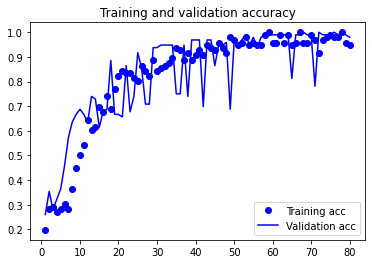

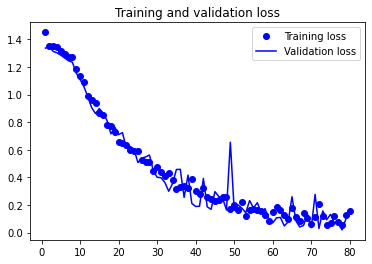

In [54]:
import matplotlib
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Lets try that previous prediction exercise against the new model and improved training approach.

In [55]:
predict_test_datagen = WaveformDataGenerator(model_ctx, df=test, type_classes = type_classes, input_size = 256, batch_size = 4, shuffle= False, to_fit = False)

print(type_classes)
print(test)
predictions = generation_alpha.predict(predict_test_datagen)

print([type_classes[i] for i in np.argmax(predictions, axis=-1)])

['sine' 'sawtooth' 'square' 'triangle']
                    name      type  frequency  amplitude  phase  bias
121   triangle_5hz_45deg  triangle        5.0        1.0   45.0   0.0
16        sine_4hz_45deg      sine        4.0        1.0   45.0   0.0
123  triangle_5hz_135deg  triangle        5.0        1.0  135.0   0.0
56    sawtooth_2hz_45deg  sawtooth        2.0        1.0   45.0   0.0
18       sine_4hz_135deg      sine        4.0        1.0  135.0   0.0
105         triangle_2hz  triangle        2.0        1.0    0.0   0.0
55          sawtooth_2hz  sawtooth        2.0        1.0    0.0   0.0
22        sine_5hz_90deg      sine        5.0        1.0   90.0   0.0
91      square_4hz_45deg    square        4.0        1.0   45.0   0.0
77      square_1hz_90deg    square        1.0        1.0   90.0   0.0
68   sawtooth_4hz_135deg  sawtooth        4.0        1.0  135.0   0.0
79     square_1hz_180deg    square        1.0        1.0  180.0   0.0
2         sine_1hz_90deg      sine        1.0     

Well that looks much better, especially now I'm converting the prediction output matrix to a more definitive list of types.

Let's under line Generation Alpha here as the model itself appears to be 100% reliable with the validation data.

Just out of interest, how does it cope if we ~shuffle~<sup>*</sup> and permutate the test data.
No shuffle as I have no idea which wave was feed into the model for each step ;)

In [56]:
predict_test_datagen = WaveformDataGenerator(model_ctx, df=test, type_classes = type_classes, input_size = 256, batch_size = 4, shuffle= False, frequency_multiplier_range = 0.5, to_fit = False)

print(type_classes)
print(test)
predictions = generation_alpha.predict(predict_test_datagen)

print([type_classes[i] for i in np.argmax(predictions, axis=-1)])

['sine' 'sawtooth' 'square' 'triangle']
                    name      type  frequency  amplitude  phase  bias
121   triangle_5hz_45deg  triangle        5.0        1.0   45.0   0.0
16        sine_4hz_45deg      sine        4.0        1.0   45.0   0.0
123  triangle_5hz_135deg  triangle        5.0        1.0  135.0   0.0
56    sawtooth_2hz_45deg  sawtooth        2.0        1.0   45.0   0.0
18       sine_4hz_135deg      sine        4.0        1.0  135.0   0.0
105         triangle_2hz  triangle        2.0        1.0    0.0   0.0
55          sawtooth_2hz  sawtooth        2.0        1.0    0.0   0.0
22        sine_5hz_90deg      sine        5.0        1.0   90.0   0.0
91      square_4hz_45deg    square        4.0        1.0   45.0   0.0
77      square_1hz_90deg    square        1.0        1.0   90.0   0.0
68   sawtooth_4hz_135deg  sawtooth        4.0        1.0  135.0   0.0
79     square_1hz_180deg    square        1.0        1.0  180.0   0.0
2         sine_1hz_90deg      sine        1.0     

Okay, so far so good, the prediction is working for signals with frequencies that the model was not trained with - that is on the assumption that the frequency permutations are actually occurring.

As I've covered an aweful lot in this notebook I've decided to underline it, call it 'Part 1' and start a new notebook that picks out the best bits and cleans up what has been covered here.

In part two we'll cover visualisation of the model's layers and try and make some educated guesses about how efficent our model is.
